# Not obvious features

### Debt features

In [3]:
import pandas as pd

In [4]:
transactions = pd.read_csv('onlinefraud.csv')

transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
transactions['has_debt'] = transactions['amount'] > transactions['oldbalanceOrg']
transactions['debt'] = (transactions['amount'] - transactions['oldbalanceOrg']) * transactions['has_debt']

### Features associated with destination account

Let's group data by destination and calculated some statistics. It can provide us with not obvious features.

In [6]:
from tqdm import tqdm
grouped_transactions = transactions.groupby('nameDest')
info_for_group = pd.DataFrame()
info_for_group['origins_count'] = grouped_transactions['nameOrig'].count()
columns_of_interest = [
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'step',
    # remove these columns to avoid linear dependency between columns
    # 'actual_amount_spent',
    # 'actual_amount_received',
    'has_debt'
]

aggregation_methods = ['min', 'max', 'std', 'median', 'mean']
for column in tqdm(columns_of_interest):
    for method in aggregation_methods:
        info_for_group[f'{method}_{column}'] = grouped_transactions[column].aggregate(method)

transactions = pd.merge(
    left=transactions,
    right=info_for_group.reset_index(),
    on='nameDest'
)

100%|██████████| 7/7 [00:18<00:00,  2.70s/it]


In [7]:
has_none = transactions.isna().any(axis=0)
has_none[has_none]

std_amount            True
std_oldbalanceOrg     True
std_newbalanceOrig    True
std_oldbalanceDest    True
std_newbalanceDest    True
std_step              True
std_has_debt          True
dtype: bool

Std columns has none when there is no deviations among data. Let's fill it with zero.

In [8]:
transactions.fillna(0, inplace=True)

In [9]:
has_none = transactions.isna().any(axis=0)
has_none[has_none]

Series([], dtype: bool)

Now each transaction contains information about all transaction of its destination account. Thus, we have to keep all transactions with the same destination in one group to prevent data leak.

In [10]:
transactions.groupby('nameDest')['isFraud'].std().mean()

0.0047010514797013

As we can see, this value is not zero, so transactions with the same destination can be either fraud or not, but we still need to keep the whole group in one set (train/test/validation).

### Account type

Account name start with letter M or C, which can indicate different types of accounts.

In [11]:
transactions['nameDestFirstLetter'] = transactions['nameDest'].str[0]

<AxesSubplot: >

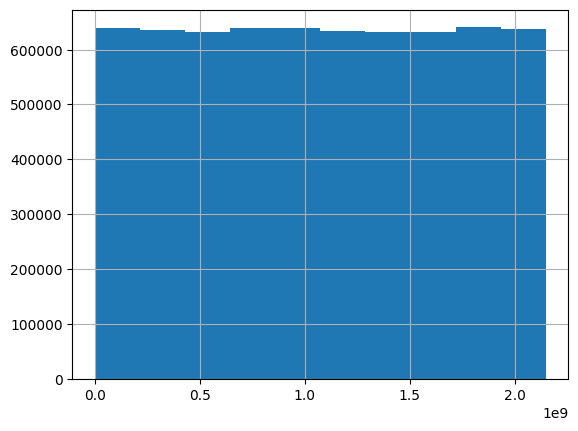

In [12]:
transactions['nameDest'].str[1:].astype(int).hist()

As we can see, number of bank account looks like random variable which doesn't contain any information.

### Money related features

In [13]:
# fraudsters more probably don't specify cents or even ones
transactions['amount_has_cents'] = (transactions['amount'] % 1 != 0)
transactions['amount_has_units'] = (transactions['amount'] % 10 != 0)
transactions['amount_has_tens'] = (transactions['amount'] % 100 != 0)
transactions['amount_has_hundreds'] = (transactions['amount'] % 1000 != 0)
# fraudsters can try to transfer all available money
transactions['amount_is_equal_to_balance'] = (transactions['amount'] == transactions['oldbalanceOrg'])

### Categorical variables encoding

In [14]:
transactions.dtypes

step                            int64
type                           object
amount                        float64
nameOrig                       object
oldbalanceOrg                 float64
newbalanceOrig                float64
nameDest                       object
oldbalanceDest                float64
newbalanceDest                float64
isFraud                         int64
isFlaggedFraud                  int64
has_debt                         bool
debt                          float64
origins_count                   int64
min_amount                    float64
max_amount                    float64
std_amount                    float64
median_amount                 float64
mean_amount                   float64
min_oldbalanceOrg             float64
max_oldbalanceOrg             float64
std_oldbalanceOrg             float64
median_oldbalanceOrg          float64
mean_oldbalanceOrg            float64
min_newbalanceOrig            float64
max_newbalanceOrig            float64
std_newbalan

In [15]:
categorical_variables = ['type', 'nameDestFirstLetter']

for variable in categorical_variables:
    transactions[f'{variable}_code'] = pd.Categorical(transactions[variable]).codes
    for value in transactions[variable].unique()[:-1]:
        transactions[f'{variable}={value}'] = transactions[variable] == value

### Drop extra features

In [16]:
pd.set_option('display.max_columns', 500)
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,has_debt,debt,origins_count,min_amount,max_amount,std_amount,median_amount,mean_amount,min_oldbalanceOrg,max_oldbalanceOrg,std_oldbalanceOrg,median_oldbalanceOrg,mean_oldbalanceOrg,min_newbalanceOrig,max_newbalanceOrig,std_newbalanceOrig,median_newbalanceOrig,mean_newbalanceOrig,min_oldbalanceDest,max_oldbalanceDest,std_oldbalanceDest,median_oldbalanceDest,mean_oldbalanceDest,min_newbalanceDest,max_newbalanceDest,std_newbalanceDest,median_newbalanceDest,mean_newbalanceDest,min_step,max_step,std_step,median_step,mean_step,min_has_debt,max_has_debt,std_has_debt,median_has_debt,mean_has_debt,nameDestFirstLetter,amount_has_cents,amount_has_units,amount_has_tens,amount_has_hundreds,amount_is_equal_to_balance,type_code,type=PAYMENT,type=TRANSFER,type=CASH_IN,type=CASH_OUT,nameDestFirstLetter_code,nameDestFirstLetter=M
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,False,-0.00,1,9839.64,9839.64,0.000000,9839.640,9839.640000,170136.0,170136.00,0.000000e+00,170136.0,1.701360e+05,160296.36,160296.36,0.000000e+00,160296.36,1.602964e+05,0.0,0.00,0.000000e+00,0.00,0.000000e+00,0.0,0.00,0.000000e+00,0.00,0.000000e+00,1,1,0.000000,1.0,1.000000,False,False,0.000000,0.0,0.000000,M,True,True,True,True,False,3,True,False,False,False,1,True
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,False,-0.00,1,1864.28,1864.28,0.000000,1864.280,1864.280000,21249.0,21249.00,0.000000e+00,21249.0,2.124900e+04,19384.72,19384.72,0.000000e+00,19384.72,1.938472e+04,0.0,0.00,0.000000e+00,0.00,0.000000e+00,0.0,0.00,0.000000e+00,0.00,0.000000e+00,1,1,0.000000,1.0,1.000000,False,False,0.000000,0.0,0.000000,M,True,True,True,True,False,3,True,False,False,False,1,True
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,False,0.00,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,False,True,True,True,True,4,False,True,False,False,0,False
3,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0,True,68134.65,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,True,True,True,True,False,4,False,True,False,False,0,False
4,7,CASH_IN,10256.20,C111105514,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,0,False,-0.00,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,True,True,True,True,False,0,False,False,True,False,0,False


In [17]:
extra_features = [
    'type',
    'nameDest',
    'nameOrig'
]
transactions.drop(columns=extra_features, inplace=True)

### Save results

In [19]:
transactions.to_csv('onlinefraud_with_features.csv')